# Study of the reliability of loaners

## Opening the dataset

In [33]:
import pandas as pd

In [34]:
data = pd.read_csv('/Users/asyl/Desktop/DS/sources/credit.csv')
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Data preprocessing

### Deleting missing values

In [36]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [37]:
# missing values in income type
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Processing anomalies

In [38]:
data['days_employed'] = data['days_employed'].abs()

In [39]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

Two types (unemployed and pensioners) get abnormally large values. Correcting such values is difficult, so we leave them as they are.

In [40]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

In [41]:
data = data[(data['children'] != -1) & (data['children'] != 20)]
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

In [42]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [43]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Changing data types

In [44]:
data['total_income'] = data['total_income'].astype(int)

### Duplicates

In [45]:
data.duplicated().sum()

54

In [46]:
data = data.drop_duplicates()

In [47]:
data['education'] = data['education'].str.lower()

### Data categorization

In [48]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [49]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

In [50]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [51]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [52]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Research

We will check the relationship between the number of children and the repayment of the loan on time by building a pivot table based on the values of the `children` and `debt` columns.

First, let's define what values they store in themselves. The `children` column has already been processed before, and we know that the number of children varies from 0 to 5. And `debt` at first glance has only 2 values and probably indicates whether the client has a debt or not.

In [53]:
# looking at cchildren column
print('Number of clients by number of children:')
print(data['children'].value_counts())

Number of clients by number of children:
0    14107
1     4809
2     2052
3      330
4       41
5        9
Name: children, dtype: int64


Now let's look at the unique `debt` values. <a id='debt'></a>

In [54]:
# debt column values
data['debt'].value_counts()

0    19616
1     1732
Name: debt, dtype: int64

The guess was confirmed, the `debt` column has 2 unique values, where `0`, logically, means no delay.

Knowing what values we are dealing with, it is possible to build a summary table of the ratio of the number of children to the presence of loan debt.

,clients_count,clients_share,debt_mean
children,,,
0,14107,66.08%,7.54%
1,4809,22.53%,9.23%
2,2052,9.61%,9.45%
3,330,1.55%,8.18%
4,41,0.19%,9.76%
5,9,0.04%,0.00%


AxesSubplot(0.125,0.11;0.775x0.77)


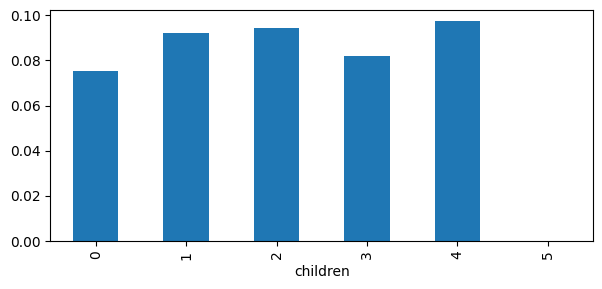

In [55]:
# creating pivot_table
children_pivot = data.pivot_table(index='children', values='debt', aggfunc={'mean', 'count'})
children_pivot.insert(1, 'modal_share', children_pivot['count'] / children_pivot['count'].sum())
children_pivot.columns = ['clients_count', 'clients_share', 'debt_mean']
children_pivot['clients_count'] = children_pivot['clients_count'].astype(int)
with pd.option_context('display.float_format', '{:.2%}'.format):
    display(children_pivot)
print(children_pivot['debt_mean'].plot.bar(figsize=(7, 3)))

The diagram above shows a relatively even distribution of arrears among clients with different numbers of children. With an increase in the number of children in the family, a slight increase in the delinquency rate of the loan is visible (the total increase was `2.2%`), while the category of families with 3 children is slightly out of the general trend and shows a slight decrease in the delinquency rate. Judging only by this graph, we can say that families with many children more often do not meet the deadline for paying debts on loans, on the other hand, much fewer of these people initially take out loans. The category of people with 5 children has no delays, but they are only 9 people, such a sample is not representative.

### **Conclusion: the relationship between the number of children and the repayment of the loan on time**

The analysis performed showed a slight increase in the loan repayment arrears ratio with an increase in the number of children per family. Data for clients with 5 children is insufficient for analysis.

The principle of action is similar to the previous task - we study the presented data, then proceed to the analysis. [Column `debt`](#debt) we already know, take a look at marital status categories.

In [56]:
print('family_status values:')
print(data['family_status'].value_counts())
print()
print('family_status_id values:')
print(data['family_status_id'].value_counts())
print()

family_status values:
женат / замужем          12266
гражданский брак          4146
Не женат / не замужем     2796
в разводе                 1189
вдовец / вдова             951
Name: family_status, dtype: int64

family_status_id values:
0    12266
1     4146
4     2796
3     1189
2      951
Name: family_status_id, dtype: int64



In connection with the correspondence of the number of people in different categories of marital status and identifiers, suppose that each category corresponds to a different identifier. Let's build a summary table of the dependence of marital status on the violation of the deadlines for paying credit debts, at the same time we will check our assumption regarding identifiers.

,,clients_count,clients_share,debt_mean
family_status,family_status_id,,,
Не женат / не замужем,4,2796,13.10%,9.76%
гражданский брак,1,4146,19.42%,9.29%
женат / замужем,0,12266,57.46%,7.56%
в разводе,3,1189,5.57%,7.06%
вдовец / вдова,2,951,4.45%,6.62%



AxesSubplot(0.125,0.11;0.775x0.77)


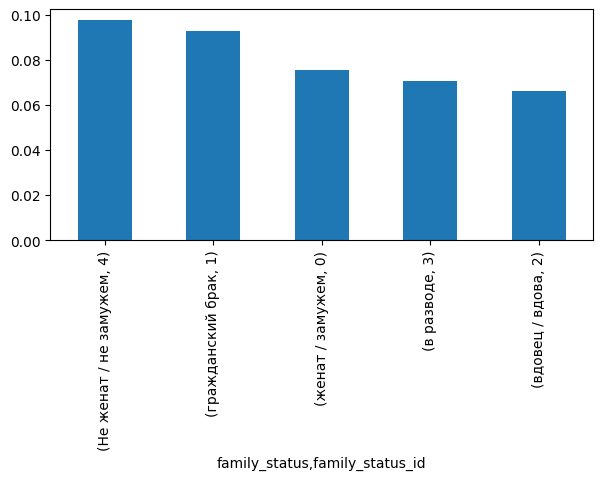

In [57]:
# dependecy table between family_status and debt
family_status_pivot = data.pivot_table(index=['family_status', 'family_status_id'], values='debt', aggfunc={'count', 'mean'}).sort_values(by='mean', ascending=False)
family_status_pivot.insert(1, 'modal_share',  family_status_pivot['count'] / family_status_pivot['count'].sum())
family_status_pivot.columns = ['clients_count', 'clients_share', 'debt_mean']
family_status_pivot['clients_count'] = family_status_pivot['clients_count'].astype(int)
with pd.option_context('display.float_format', '{:.2%}'.format):
    display(family_status_pivot)
print()
print(family_status_pivot['debt_mean'].plot.bar(figsize=(7,3)))

More than half of all clients are married people, they are also among the most responsible in terms of paying debts on time, along with the divorced and widowed categories. Their overdue ratio is in the region of `6.6-7.5%`.

Worse discipline is in the categories of single and civil marriage, their ratio exceeds `9.2%`.

### **Conclusion: relationship between marital status and loan repayment on time**

The analysis showed that people who have never been officially married before are slightly more inclined to violate the terms of repayment of debt on a loan.

In the first part of the project, we have already processed the empty values and the display format of the `total_income` column, and also divided the customers into [5 income categories.](#total_income_category)
We can start analyzing right away.

,clients_count,clients_share,debt_mean
total_income_category,,,
A,25,0.12%,8.00%
B,5014,23.49%,7.06%
C,15938,74.66%,8.49%
D,349,1.63%,6.02%
E,22,0.10%,9.09%



AxesSubplot(0.125,0.11;0.775x0.77)


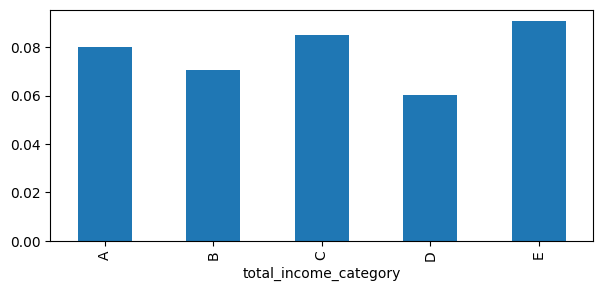

In [58]:
# creating pivot table
income_pivot = data.pivot_table(index='total_income_category', values='debt', aggfunc={'count', 'mean'}).sort_values(by='total_income_category')
income_pivot.insert(1, 'modal_share', income_pivot['count'] / income_pivot['count'].sum())
income_pivot.columns = ['clients_count', 'clients_share', 'debt_mean']
income_pivot['clients_count'] = income_pivot['clients_count'].astype(int)
with pd.option_context('display.float_format', '{:.2%}'.format):
    display(income_pivot)
print()
print(income_pivot['debt_mean'].plot.bar(figsize=(7,3)))

So, we found out that about `75%` of customers have an average income level, another `23%` - above average, and the remaining three categories account for less than `2%`.

There is also a scatter in the overdue loan repayment ratio. The category of people with low income has the highest delinquency rate (9.1%). In the anti-rating, they are followed by the largest group with an average income level `(8.5%)`. Then the high-income categories `(8%)` and above average `(7%)`. The lowest figure of `6%` keeps the category with an income below the average.

### **Conclusion: relationship between income level and loan repayment on time**

The level of income affects the fact of issuing a loan much more than its timely repayment. `98%` of clients have an average or higher income level. The rest, apparently, are rarely approved or they themselves do not need loans.

If we consider only the main part of clients (the above `98%`), then it becomes clear that high income has a positive effect on loan repayment on time. For other categories, the sample is too small to draw fundamental conclusions; single anomalous cases (for example, fraud) can greatly affect the final result.

[Loan objectives](#purpose) were defined in the first part of the project and have 4 categories
- `car operations`,
- `real estate transactions`,
- `wedding`,
- `getting an education`.

,clients_count,clients_share,debt_mean
purpose_category,,,
операции с недвижимостью,10754,50.37%,7.25%
операции с автомобилем,4281,20.05%,9.34%
получение образования,3989,18.69%,9.25%
проведение свадьбы,2324,10.89%,7.87%



AxesSubplot(0.125,0.11;0.775x0.77)


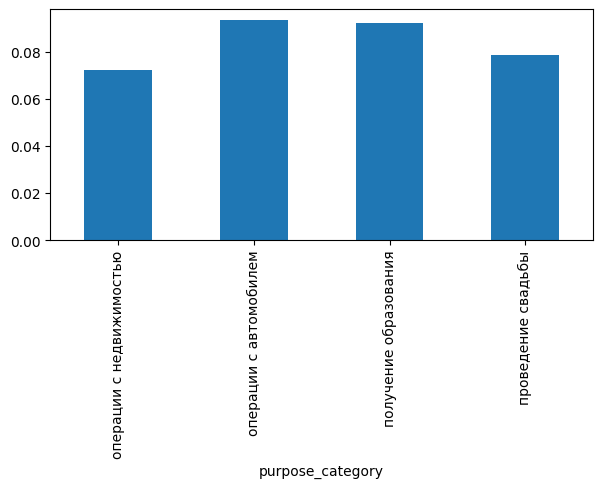

In [59]:
# creating pivot table
purpose_pivot = data.pivot_table(index='purpose_category', values='debt', aggfunc={'count', 'mean'}).sort_values(by='count', ascending=False)
purpose_pivot.insert(1, 'modal_share', purpose_pivot['count'] / purpose_pivot['count'].sum())
purpose_pivot.columns = ['clients_count', 'clients_share', 'debt_mean']
purpose_pivot['clients_count'] = purpose_pivot['clients_count'].astype(int)
with pd.option_context('display.float_format', '{:.2%}'.format):
    display(purpose_pivot)
print()
print(purpose_pivot['debt_mean'].plot.bar(figsize=(7,3)))

Half of all loans are issued for real estate transactions, they also have the lowest delinquency rate (`7.25%`). The overdue ratio (`7.87%`) is slightly higher for those few loans that were issued for wedding celebrations.

Less frequently paid on time are loans issued for car and education operations, which also have an equal quantitative ratio (at `20%` for each category) - their delinquency rate is approximately `9.3%`.

### **Conclusion: The relationship between the objectives of the loan and its repayment on time**

It turns out that loans for real estate transactions and for weddings are more often paid on time than other categories presented. This is probably due to the responsible approach of the first category and the high payback of the last category.

Automotive loans and education loans have roughly the same statistics, and their delinquency rate exceeds `9%`.

## General conclusion

As part of the study of the reliability of bank borrowers, the influence of such indicators as the number of children of the client, marital status, income level and the purpose of the loan on the fact of closing the loan on time was determined.

When processing the input database from the bank, errors and missing values ​​were found and processed in the data on the number of children in the family, total work experience, age of clients and monthly income. Additional generalizing categories by income level and purpose of the loan have been added.

The analysis revealed a slight negative impact of the presence of children on the timely payment of debt on loans. Although there is not enough data on large families, nevertheless, with an increase in the number of children in a family, an increase in the delinquency rate is observed.

The semen status of the client also has little effect. So, people who have never been officially married before have a little more arrears on loans.

Additionally, the factor of loan repayment on time is influenced by the client's income level and the purpose of the loan, which must also be taken into account when building a credit scoring model.